# Utils

In [8]:
import warnings
import umap
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import hdbscan
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt


warnings.simplefilter(action='ignore', category=FutureWarning)

from analysis import umap_run, clustering_evaluation, clustering
from preprocessing import processflat

importlib.reload(umap_run)
importlib.reload(clustering_evaluation)
importlib.reload(clustering)
importlib.reload(processflat)

from preprocessing.processflat import x_features_return
from analysis.clustering import plot_clusters_vs_groups
from analysis.umap_run import run_umap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# FC maps directories
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"

# Path to masks
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'

# Metadata
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'
path_df_meta = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/meta/df_meta.csv"

# Done dataframe of preprocessed FC maps
path_df_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_gm.pkl"
path_df_thr02_gm = "/Users/emmatosato/Documents/PhD/ANM_Verona/data/dataframes/fdc/df_thr02_gm.pkl"

# Umap

## Input Data

For the further analysis we will remove the ID labels columns, but the order is maintained.

Possible dataset from mean maps:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Possible dataset from mean network:
- `df_networks_no_thr`
- `df_networks_thr01`
- `df_networks_thr02`

Here we go with one example

In [10]:
# Load dataframes
df_gm = pd.read_pickle(path_df_gm)
df_meta = pd.read_csv(path_df_meta)

# Merge with metadata
df_merged, X = x_features_return(df_gm, df_meta)


-------------------- Dataset Info --------------------
Meta columns (Labels and Covariates):       10
Feature matrix shape (X):                (176, 161817)
Complete dataframe shape after merge:    (176, 161827)
-------------------------------------------------------



## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [11]:
np.random.seed(42)

In [12]:
# Parameters
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

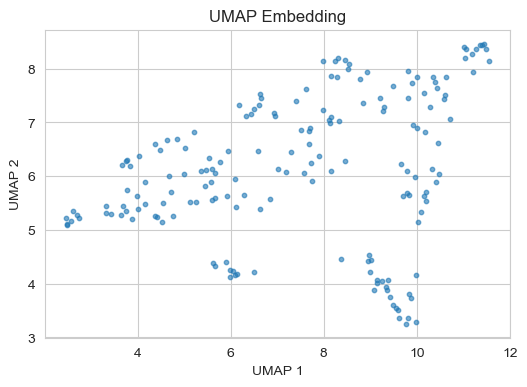

In [13]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

# Unsupervised Clustering

## Fit models

In [14]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=7, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

Result collection

In [15]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    "K-Means": labels_km,
}

labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'Group': df_merged['Group'],
    'CDR_SB': df_merged['CDR_SB'],
    'MMSE': df_merged['MMSE'],
    'labels_gmm_cdr': df_merged['labels_gmm_cdr'],
    'HDBSCAN': labels_hdb,
    'KMeans': labels_km,
})


## Statistical Evaluation

In [12]:
diagnoses = ['ADNI', 'CBS', 'PSP']

for diag in diagnoses:
    print(f"\n=== Chi-squared test for {diag} ===")

    # Crea colonna binaria con etichette leggibili
    labels_df[f'{diag}_label'] = labels_df['Group'].apply(lambda x: diag if x == diag else 'other')

    # Tabella di contingenza: Cluster vs (diag vs other)
    contingency = pd.crosstab(labels_df['KMeans'], labels_df[f'{diag}_label'])
    print("Contingency Table:")
    print(contingency)

    # Chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency)

    # Output
    print(f"\nChi² = {chi2:.4f}")
    print(f"p-value = {p_value:.4f}")
    print(f"Degrees of Freedom = {dof}")


=== Chi-squared test for ADNI ===
Contingency Table:
ADNI_label  ADNI  other
KMeans                 
0             25     41
1             25     53
2             22     10

Chi² = 13.0431
p-value = 0.0015
Degrees of Freedom = 2

=== Chi-squared test for CBS ===
Contingency Table:
CBS_label  CBS  other
KMeans               
0           17     49
1           21     57
2            6     26

Chi² = 0.8407
p-value = 0.6568
Degrees of Freedom = 2

=== Chi-squared test for PSP ===
Contingency Table:
PSP_label  PSP  other
KMeans               
0           24     42
1           32     46
2            4     28

Chi² = 8.4602
p-value = 0.0146
Degrees of Freedom = 2
